In [1]:
pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 147 kB 7.7 MB/s 
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=8831d8a0a16d61141c5bc72da1d76e52bd240293592b1121e59a6709d3093513
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings
from pyod.models.ocsvm import OCSVM
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
from pickle import dump, load

#### Data Loading

In [3]:
df=pd.read_pickle('https://drive.google.com/uc?id=1YX0Hpx9G3QZXqmuoXE8A3_C5atpgo81G')

In [4]:
df.head()

,IDATE,LAT,LON,ELEVATION_m,PPT_mm,TMIN_c,TMEAN_c,TMAX_c,TDMEAN_c,lfmc_mean,lfmc_stdv,Mean_Sea_Level_Pressure,Mean_Station_Pressure,Mean_Wind_Speed,Maximum_Sustained_Wind_Speed,VPD9AM_hpa,VPD3PM_hpa
0,0.0,0.250576,0.179574,0.223896,0.0,0.427626,0.447125,0.486874,0.738624,0.107583,0.212526,0.404444,0.525210,0.085729,0.367457,0.393151,0.422969
1,0.0,0.197867,0.189637,0.284137,0.0,0.461583,0.466090,0.488730,0.740741,0.194569,0.175128,0.406667,0.533613,0.073122,0.367457,0.376416,0.411485
2,0.0,0.203466,0.189485,0.330321,0.0,0.454101,0.458352,0.482100,0.743915,0.210215,0.137647,0.404444,0.532213,0.075139,0.367457,0.377703,0.413445
3,0.0,0.203666,0.189536,0.329317,0.0,0.454101,0.458352,0.482100,0.743915,0.194408,0.132680,0.404444,0.532213,0.075139,0.367457,0.377703,0.413445
4,0.0,0.204106,0.189441,0.327309,0.0,0.454101,0.458352,0.482100,0.743915,0.269143,0.158312,0.404444,0.532213,0.075139,0.367457,0.377703,0.413445


In [5]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=False)
#Labels for PyOD 0 = inlier, 1 = outlier 
y_train=np.zeros(X_train.shape[0])
y_test=np.zeros(X_test.shape[0])
print("Train set data size : "+str(X_train.shape))
print("Test set data size : "+str(X_test.shape))

Train set data size : (26640, 17)
Test set data size : (6660, 17)


#### Hyper Parameter Tuning

In [6]:
# # Specify each parameter to find the best value for. Either a range of values or a set of predefined options can be specified for each parameter
# warnings.filterwarnings('ignore')
# space = {'gamma': hp.choice('gamma', ['auto']),
#         'degree': hp.quniform('degree', 1, 8 ,1),
#         'kernel': hp.choice('kernel', ['rbf','linear', 'poly', 'sigmoid']),
#         'nu': hp.uniform('nu', 0.01, 0.99)
#     }

# # The objective function is a combination of the learner and the parameters that you want to find the best values for. "model" can be changed to any learner 
# # The "accuracy" returned is the result of a standard accuracy score but doesn't involved cross validation but this code could be modified to do this
# def objective(space):
#     model = OCSVM(  gamma = space['gamma'], 
#                     degree = space['degree'],
#                     kernel = space['kernel'],
#                     nu = space['nu']
#                  )
#     model.fit(X_train)
#     avgprob = np.average(model.predict_proba(X_train)[:,0])
#     # We aim to maximize accuracy, therefore we return it as a negative value
#     return {'loss': -avgprob, 'status': STATUS_OK }
 
# # "fmin" minimises the objective function i.e. finds the set of parameters that results in the learner's best accuracy    
# trials = Trials()
# best = fmin(fn= objective,
#             space= space,
#             algo= tpe.suggest,
#             max_evals = 100,
#             trials= trials)
# warnings.filterwarnings(action='once')
# print(best)

#### Model Training

In [7]:
estimator=OCSVM(nu=0.988,degree=2, gamma='auto')
estimator.fit(X_train)

OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=2, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.988, shrinking=True, tol=0.001,
   verbose=False)

In [8]:
dump(estimator, open('11_WA_OCSVM.pkl', 'wb'))

#### Train set AVG Probability of Being Inlier

In [9]:
P1=estimator.predict_proba(X_train)[:,0]
print("Training set Mean :  ",round(np.mean(P1),6))
print("Training set STD :  ",round(np.std(P1),6))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


Training set Mean :   0.734168
Training set STD :   0.132768


#### Test set AVG Probability of Being Inlier

In [10]:
P2=estimator.predict_proba(X_test)[:,0]
print("Test set Mean :  ",round(np.mean(P2),6))
print("Test set STD :  ",round(np.std(P2),6))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


Test set Mean :   0.763312
Test set STD :   0.122741


#### All set AVG Probability of Being Inlier

In [11]:
P=np.append(P1,P2)
print("All Mean :  ",round(np.mean(P),6))
print("All STD :  ",round(np.std(P),6))

All Mean :   0.739997
All STD :   0.131342


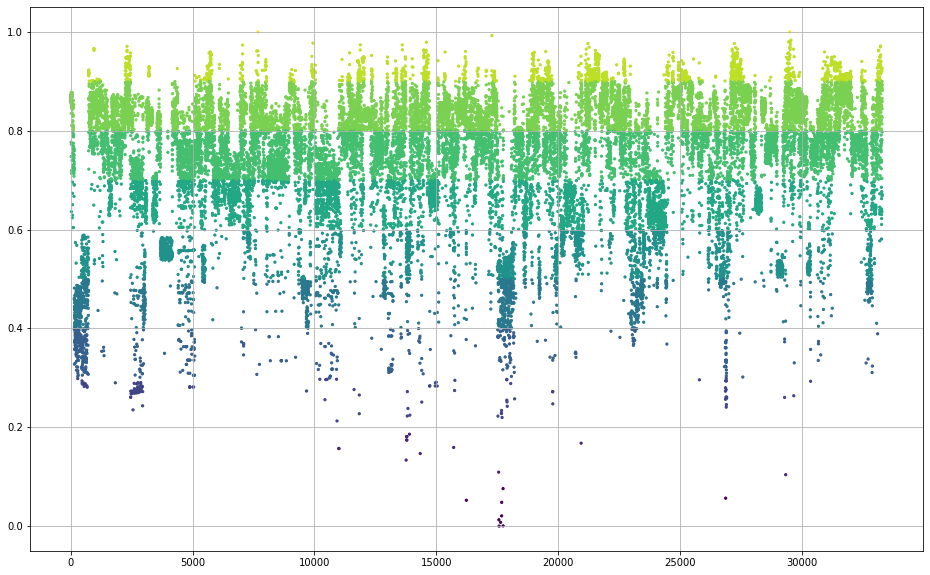

In [12]:
fig, ax = plt.subplots(figsize=(16,10))
im=ax.scatter(x=df.index,y=P,c=np.multiply(P,10).astype(int),s=5)
ax.grid(True)
plt.show()

In [13]:
#estimator.explain_outlier(1000)

#### Feature Importance

In [ ]:
warnings.filterwarnings('ignore')
#k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, random_state=1))
k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, nsamples=100, random_state=1))
X_test_sample=shap.sample(X_test,random_state=1)
k_shap_values = k_explainer.shap_values(X_test_sample) # More Sample Need more time
warnings.filterwarnings('once')

In [ ]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample, plot_type="bar")

In [ ]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample)

In [ ]:
shap.initjs()
shap.force_plot(k_explainer.expected_value, k_shap_values, X_test_sample)

In [ ]:
feature_names = X_train.columns
rf_resultX = pd.DataFrame(k_shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name','feature_importance_vals'])
#shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_importance